### Name: Binben Wang
### NSID: biw123

In [1]:
import os
import folium
import numpy as np
import pandas as pd
import pyproj as pj
import math
from folium.plugins import HeatMap
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
import scipy.stats as stats
import pylab as pl
import networkx as nx
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# STEP 1: Preparation

In [2]:
# gps.csv contains five features: user_id, record_time, latitude, longitude, accu
gps_df = pd.read_csv("../A1/gps.csv")
# battery.csv contains two features: user_id, record_time
battery_df = pd.read_csv("../A1/battery.csv")

In [3]:
# latitude and longitude of saskatoon center
lat_center_saskatoon = (52.058367 + 52.214608) / 2
lon_center_saskatoon = (-106.7649138128 - 106.52225318) / 2

In [4]:
# calculate number of total possible battery records per particiants
battery_df.record_time = battery_df.record_time.astype('datetime64')
time_interval = battery_df.record_time.max() - battery_df.record_time.min()
num_total_possible_records = np.ceil(time_interval.total_seconds() / 300)

In [5]:
# calculate the number of all battery records per user.
battery_counts_df = battery_df.groupby(['user_id']).size().reset_index(name='counts')

In [6]:
# filter battery dataframe in 50% threshold
fifty_user_df = battery_counts_df[battery_counts_df.counts >= num_total_possible_records * 0.5]

In [7]:
analysis_gps_df = gps_df[(gps_df.lat <= 52.214608) & (gps_df.lat >= 52.058367) & (gps_df.lon <= -106.52225318) & (gps_df.lon >= -106.7649138128) & (gps_df.accu < 100) & (gps_df.user_id.isin(fifty_user_df.user_id.values.tolist()))]

In [8]:
# drop the accu column, it is useless now
analysis_gps_df = analysis_gps_df.drop(columns=['accu'])

In [9]:
# calculate the minimum timestamp of all records
analysis_gps_df.record_time = analysis_gps_df.record_time.astype('datetime64')
min_timestamp = analysis_gps_df.record_time.min()

In [10]:
# convert record_time to relative_time by duty cycle
analysis_gps_df.loc[:, 'relative_time'] = np.floor((analysis_gps_df.record_time - min_timestamp).dt.total_seconds() / 300).astype('int')

In [11]:
analysis_gps_df = analysis_gps_df.groupby(['user_id', 'relative_time']).mean().reset_index()

In [12]:
# transfer latitude and longitude coordinates to UTM coordinates
p1 = pj.Proj(init='epsg:32613')
x, y = p1(analysis_gps_df.lon.values.tolist(), analysis_gps_df.lat.values.tolist())
analysis_gps_df.loc[:, 'x'] = x
analysis_gps_df.loc[:, 'y'] = y

In [13]:
# calculate the start and end coordinates in UTM for the greater Saskatoon area
start_x, start_y = p1(-106.7649138128, 52.058367)
end_x, end_y = p1(-106.52225318, 52.214608)

In [14]:
# convert UTM coordinates into grid coordinates
def which_grid(x, y, start_x, start_y, step):
    which_grid_x = np.floor((x - start_x) / step)
    which_grid_y = np.floor((y - start_y) / step)
    
    # in case UTM coordinates in the boundary of the greater Saskatoon area
    # there are some -1 value appearing
    # set all -1 to 0
    which_grid_x[which_grid_x < 0] = 0
    which_grid_y[which_grid_y < 0] = 0
    
    return(which_grid_x, which_grid_y)

In [15]:
analysis_gps_df.loc[:, 'grid_x'], analysis_gps_df.loc[:, 'grid_y'] = which_grid(analysis_gps_df.x.values, analysis_gps_df.y.values, start_x, start_y, 100)

In [16]:
#convert datatype from float64 to int
analysis_gps_df.grid_x = analysis_gps_df.grid_x.astype('int')
analysis_gps_df.grid_y = analysis_gps_df.grid_y.astype('int')

In [17]:
# Convert grid coordinates back to lat and lon coordinates
temp_x = (analysis_gps_df.grid_x + 0.5) * 100 + start_x
temp_y = (analysis_gps_df.grid_y + 0.5) * 100 + start_y
temp_x[temp_x > end_x] = end_x
temp_y[temp_y > end_y] = end_y

analysis_gps_df.lon, analysis_gps_df.lat = p1(temp_x.tolist(), temp_y.tolist(), inverse=True)

In [18]:
# drop columns: x, y
analysis_gps_df = analysis_gps_df.drop(columns=['x', 'y'])

In [19]:
analysis_gps_df.describe()

,user_id,relative_time,lat,lon,grid_x,grid_y
count,249551.000000,249551.000000,249551.000000,249551.000000,249551.000000,249551.000000
mean,1070.807278,21323.029012,52.127024,-106.632350,92.095195,73.736551
std,266.220713,2495.364820,0.012796,0.035082,23.998870,14.266732
min,514.000000,0.000000,52.059410,-106.764007,2.000000,0.000000
25%,943.000000,19150.000000,52.121852,-106.639831,87.000000,68.000000
50%,1052.000000,21365.000000,52.125467,-106.633891,91.000000,72.000000
75%,1315.000000,23478.000000,52.131959,-106.629740,94.000000,80.000000
max,1364.000000,25706.000000,52.212823,-106.523774,167.000000,171.000000


# STEP 2: Find collocation

In [20]:
at_same_grid = pd.DataFrame()
valid_relative_time = []

for i in range(analysis_gps_df.relative_time.max() + 1):
    temp = analysis_gps_df[analysis_gps_df.relative_time == i]
    
    if (len(temp.user_id.unique()) >= 2) and (temp.groupby(['grid_x', 'grid_y']).size().max() >= 2):
        valid_relative_time.append(i)
        at_same_grid = at_same_grid.append(pd.concat(g for _, g in temp.groupby(['grid_x', 'grid_y']) if len(g) > 1), ignore_index=True)

In [21]:
users = at_same_grid.user_id.unique().tolist()
users.sort()

# create two dictionaries of user_id and matrix indexes
user_id_and_index = dict()
index_and_user_id = dict()

for i in range(len(users)):
    user_id_and_index[users[i]] = i
    index_and_user_id[i] = users[i]

In [24]:
pairs_df = at_same_grid.groupby(['relative_time','grid_x', 'grid_y'])['user_id'].unique().reset_index()

In [273]:
pairs_df.head(10)

,relative_time,grid_x,grid_y,user_id
0,16946,91,71,"[1052, 1297]"
1,16958,90,75,"[793, 1323]"
2,16961,90,75,"[793, 1323]"
3,16963,92,70,"[1288, 1308]"
4,16965,91,70,"[1052, 1297]"
5,16966,92,70,"[1288, 1297]"
6,16970,60,68,"[514, 551]"
7,16971,60,68,"[514, 551]"
8,16975,92,70,"[1288, 1297, 1308]"
9,16983,89,78,"[975, 1299]"


# STEP 3: Make a graph

In [25]:
mat = np.zeros([len(users), len(users)])

for i in range(len(pairs_df.user_id.tolist())):
    users_same_grid_and_time = pairs_df.user_id.tolist()[i].tolist()
    pairs = itertools.permutations(users_same_grid_and_time, 2)
    
    for pair in pairs:
        mat[user_id_and_index[pair[0]], user_id_and_index[pair[1]]] = mat[user_id_and_index[pair[0]], user_id_and_index[pair[1]]] + 1

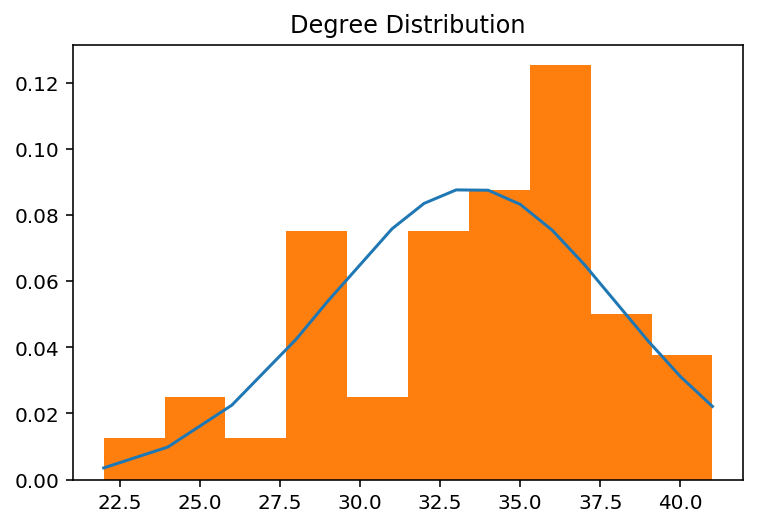

In [41]:
# construct and plot the degree distribution
degrees = (1 * (mat != 0)).sum(axis=0)

h_1 = sorted(degrees)
fit = stats.norm.pdf(h_1, np.mean(h_1), np.std(h_1)) 
pl.plot(h_1,fit)
pl.hist(h_1,density=True, alpha=1)
pl.title("Degree Distribution")
pl.show() 

In [272]:
print("minimum degree: " + str(h_1[0]))
print("maximum degree: " + str(h_1[41]))
print("mean: " + str(np.mean(h_1)))
print("standard deviation: " + str(np.std(h_1)))

minimum degree: 22
maximum degree: 41
mean: 33.476190476190474
standard deviation: 4.526315095601631


### Note degree distribution's shape, and likely statistical properties.
The minimum degree of all nodes is 22. And the maximum degree of all nodes is 41. We can see that the number of degree first increases as degree incresing and then decreases. So the shape of degree distribution is a bell, which is perfect for Gaussian distribution. The mean of this Gaussian distribution is 33.5 and the standard deviation of this distribution is 4.5.

In [43]:
# normalize the graph
mat = mat / len(at_same_grid.relative_time.unique())

In [60]:
# create a graph by numpy matrix
G = nx.from_numpy_matrix(mat)
# relabel the graph
G2 = nx.relabel_nodes(G, index_and_user_id)

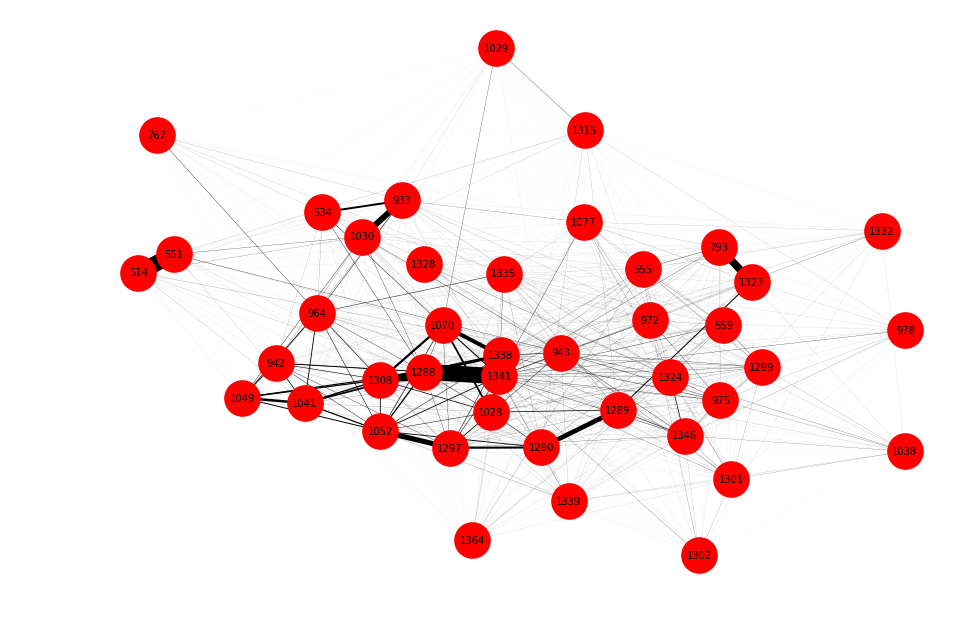

In [265]:
edges = G2.edges()
weights = [G2[u][v]['weight'] for u,v in edges]
# Use a parameter scale_up to enlarge edge weights. You can set it 1 to see orginal graph
scale_up = 20
nx.draw(G2, pos, font_size = 5, with_labels = True, edges=edges, width=(np.array(weights) * scale_up).tolist())

### Describe the contact patterns
When we set $scale\_up = 1$, we can barely see edges in the graph. So I set $scale\_up = 20$ to scale weights up. We can see that most of edges in this graph is also very faint, which means they have small weights. Also, we can see that the edge between 514 and 551, the edge between 1288 and 1341 have the two largest weights. So we know that although participants met a lot of other participants randomly and rarely, only small number of participants have regular meeting with other participants.

# STEP 4: Centrality

In [130]:
# calcuate the degree of each node
degree = dict(nx.degree(G2))

In [128]:
# calculate the betweenness of each node
betweenness = nx.betweenness_centrality(G2)

In [124]:
# calculate the eigenvector centrality of each node
centrality = nx.eigenvector_centrality(G2)

In [138]:
degree_df = pd.DataFrame.from_dict(degree, orient='index', columns=['degree'])
betweenness_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness'])
centrality_df = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality'])

In [143]:
node_attri_df = pd.merge(degree_df, betweenness_df, left_index=True, right_index=True)

In [145]:
node_attri_df = pd.merge(node_attri_df, centrality_df, left_index=True, right_index=True)

In [251]:
node_attri_df.sort_values(by=['betweenness'], inplace=True)

In [255]:
node_attri_df

,degree,betweenness,centrality
1332,26,0.001282,0.123582
767,22,0.001920,0.101170
978,29,0.001964,0.137111
551,24,0.002137,0.109443
1038,29,0.002258,0.135804
1290,29,0.002579,0.135077
1049,28,0.002704,0.129438
1029,24,0.002817,0.107055
1323,34,0.003407,0.157823
1308,31,0.003438,0.142690


### Describe three inconsistencies in the ordering of nodes between the different centrality measures by referring to the definitions of those centralities.
1. node 1052: This node is on the margin of the graph. So based on the definition of betweenness centrality, it's betweenness is relatively low. But it connects to some important nodes, it's eigenvector centnrality is relatively high.
2. node 943: This nodes connects to node 972, the most important node. And the connected edge's weight is not too small. So it's eigenvector centnrality is relatively high.
3. node 551: It's degree is very small but has a relatively large betweenness centrality because it has a strong edge with node 514. So many shortest paths have cross this edge.

# STEP 4: Cluster

In [241]:
c = list(nx.algorithms.community.modularity_max.greedy_modularity_communities(G2))

In [242]:
c

[frozenset({514}),
 frozenset({534}),
 frozenset({551}),
 frozenset({555}),
 frozenset({559}),
 frozenset({767}),
 frozenset({793}),
 frozenset({933}),
 frozenset({942}),
 frozenset({943}),
 frozenset({964}),
 frozenset({972}),
 frozenset({975}),
 frozenset({978}),
 frozenset({1028}),
 frozenset({1029}),
 frozenset({1030}),
 frozenset({1038}),
 frozenset({1041}),
 frozenset({1049}),
 frozenset({1052}),
 frozenset({1070}),
 frozenset({1077}),
 frozenset({1288}),
 frozenset({1289}),
 frozenset({1290}),
 frozenset({1297}),
 frozenset({1299}),
 frozenset({1301}),
 frozenset({1302}),
 frozenset({1308}),
 frozenset({1315}),
 frozenset({1323}),
 frozenset({1324}),
 frozenset({1328}),
 frozenset({1332}),
 frozenset({1335}),
 frozenset({1338}),
 frozenset({1339}),
 frozenset({1341}),
 frozenset({1346}),
 frozenset({1364})]

### What community structure did the algorithm create? 
From the variable $c$ in above, we can see that each node in this graph forms it's own community.
### How does this relate to what you observed in steps 3 and 4?
If we set $scale\_up = 1$ of graph visualization in step 3, we barely can see edges in the graph. Also from the table in step 4, the maximum betweenness of all nodes is 0.008472 and the maximum centrality of all nodes is 0.183288. So even all nodes have a high degree, they still cannot form communities with other nodes.